## Introduction

This dataset which is from [Kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition) which contains 4242 images of flowers. 

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. 

Here I am going to build a CNN to perform image classification with Keras from scratch.

## Data preparation

In [1]:
import os, shutil
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras import optimizers
from tensorflow.python.keras import losses
from tensorflow.python.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [22]:
orig_dataset_dir = "/home/qfen8290/mds/kaggle/datasets/flowers/"
base_dir = "/home/qfen8290/mds/kaggle/input/flowers/"
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

Let's see how many types of flowers in the dataset.

In [14]:
classes = os.listdir(orig_dataset_dir)
classes

['dandelion', 'daisy', 'rose', 'tulip', 'sunflower']

And how many pictures for each type.

In [19]:
for flower_type in os.listdir(orig_dataset_dir):
    print("There are %s pictures of %s" %(
        len(os.listdir(os.path.join(orig_dataset_dir, flower_type))), flower_type))

There are 1055 pictures of dandelion
There are 769 pictures of daisy
There are 784 pictures of rose
There are 984 pictures of tulip
There are 734 pictures of sunflower


### Create folders for training, validation and test set

In [14]:
def split_train_test_set(orig_dataset_dir, base_dir, training=0.7, validation=0.1, test=0.2):
    """
    copy the original data into folders for training, validation and test, 
    default is proportion is 0.7/0.1/0.2
    """
    
    classes = os.listdir(orig_dataset_dir)
    for dname in ['train', 'validation', 'test']:
        for klass in classes:
            full_dir_name = os.path.join(base_dir, dname, klass)
            if not os.path.exists(full_dir_name):
                os.makedirs(full_dir_name)
    
    for klass in classes:
        file_names = os.listdir(os.path.join(orig_dataset_dir, klass))
        num_samples = len(file_names)
        i = 0
        for i, fname in enumerate(file_names):
            src = os.path.join(orig_dataset_dir, klass, fname)
            if i < round(num_samples * training):
                dst = os.path.join(base_dir, "train", klass, fname)
            elif i >= round(num_samples * training) and i < round(num_samples * (training + validation)):
                dst = os.path.join(base_dir, "validation", klass, fname)
            else:
                dst = os.path.join(base_dir, "test", klass, fname)
            shutil.copyfile(src, dst)
            

In [15]:
split_train_test_set(orig_dataset_dir, base_dir)

We look at how many pictures in training, validation and test sets respectively.

In [15]:
for dname in ("train", "validation", "test"):
    num_pics = 0
    for klass in classes:
        num_pics += len(os.listdir(os.path.join(base_dir, dname, klass)))
    print("There are %s pictures of tulip in %s set" %(
        num_pics, dname))

There are 3028 pictures of tulip in train set
There are 432 pictures of tulip in validation set
There are 866 pictures of tulip in test set


Let see one of the picture of tulip.

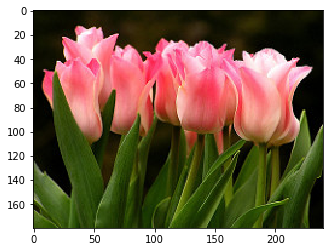

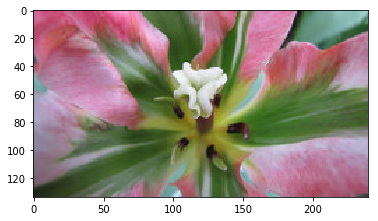

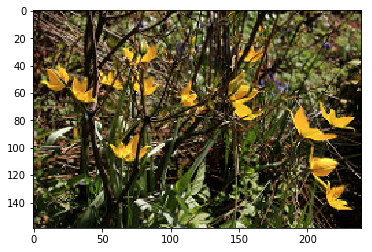

In [29]:
for dname in ("train", "validation", "test"):
    fname = os.listdir(os.path.join(base_dir, dname, "tulip"))[11]
    img = image.load_img(os.path.join(base_dir, dname, "tulip", fname))
    img_tensor = image.img_to_array(img) / 255.
    plt.imshow(img_tensor)
    plt.show()
    
# plt.show()    

## Build the convnet model with Keras

In [10]:
def simple_convnet(input_shape):
    """a simple convnet with Keras"""
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                           input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    
    model.compile(optimizer=optimizers.adam(), 
                     loss=losses.categorical_crossentropy,metrics=['accuracy'])
    return model

The input shape here is 194 x 194 x 3 (HWC) which is arbitrary. 

In [11]:
simple_model = simple_convnet((194, 194, 3))

In [12]:
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 192, 192, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 20, 20, 64)        36928     
__________

Use Keras image preprossing functions to convert images into tensors.

In [23]:
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")
train_datagen = image.ImageDataGenerator(rescale=1./255)
test_datagen = image.ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(194, 194),
    batch_size=32,
    class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(194, 194),
    batch_size=32,
    class_mode='categorical')

Found 3027 images belonging to 5 classes.
Found 430 images belonging to 5 classes.


In [31]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [20]:
history_simple = simple_model.fit_generator(
    train_generator, 
    steps_per_epoch=3027//32, 
    epochs=30, 
    validation_data=validation_generator, 
    validation_steps=430//32)

Epoch 1/30
94/94 [==============================] - 403s 4s/step - loss: 1.4292 - acc: 0.3509 - val_loss: 1.2607 - val_acc: 0.4760
Epoch 2/30
94/94 [==============================] - 381s 4s/step - loss: 1.1044 - acc: 0.5345 - val_loss: 0.9910 - val_acc: 0.6010
Epoch 3/30
94/94 [==============================] - 381s 4s/step - loss: 0.9770 - acc: 0.5964 - val_loss: 0.9146 - val_acc: 0.6514
Epoch 4/30
94/94 [==============================] - 381s 4s/step - loss: 0.8680 - acc: 0.6555 - val_loss: 0.8498 - val_acc: 0.6611
Epoch 5/30
94/94 [==============================] - 381s 4s/step - loss: 0.8102 - acc: 0.6906 - val_loss: 0.8683 - val_acc: 0.6731
Epoch 6/30
94/94 [==============================] - 382s 4s/step - loss: 0.7651 - acc: 0.7094 - val_loss: 0.8006 - val_acc: 0.7091
Epoch 7/30
94/94 [==============================] - 382s 4s/step - loss: 0.7149 - acc: 0.7276 - val_loss: 0.7494 - val_acc: 0.7019
Epoch 8/30
94/94 [==============================] - 409s 4s/step - loss: 0.6623 - a

It is a good practice to save the model after training.

In [22]:
simple_model.save('flower_classification_simple_model.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training phase.

In [26]:
acc = history_simple.history['acc']
val_acc = history_simple.history['val_acc']
loss = history_simple.history['loss']
val_loss = history_simple.history['val_loss']

epochs = [i + 1 for i in history_simple.epoch]

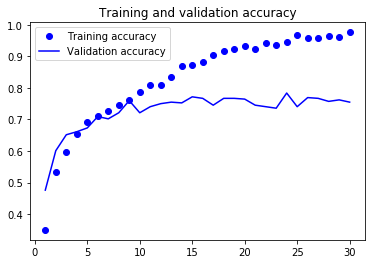

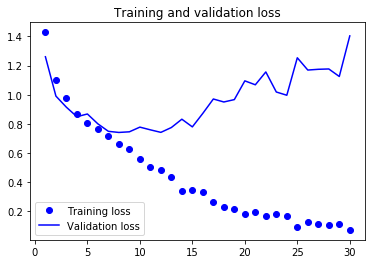

In [28]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the model seems to be overfitting after 10 epochs

Let's evaluate the test data.

In [29]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(194, 194),
    batch_size=32,
    class_mode='categorical')
test_loss, test_acc = simple_model.evaluate_generator(test_generator, steps=866//32)

Found 866 images belonging to 5 classes.


In [34]:
print("Test acc: {0:.2f}".format(test_acc * 100))

Test acc: 73.03


## Conclusion 

The accuracy for test set is 73% for 5 classes for such a small dataset (comparing to the other general image datasets). It is not a bad result for a model built from scatch. 

Let us explore the transfer learning which may help to improve the performance of classification.

### Test on my own photo

Let us test the model on the photo of tulip I took in Bowral Australia.

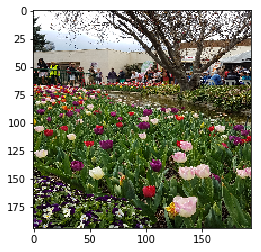

In [55]:
my_img = image.load_img("/home/qfen8290/mds/git-repos/flower_classification/20170924_112740.jpg",
                       target_size=(194, 194))
my_img_tensor = image.img_to_array(my_img) / 255.
my_img_tensor = my_img_tensor.transpose((1, 0, 2))
plt.imshow(my_img_tensor)
plt.show()

In [4]:
try:
    simple_model
except NameError:
    print("Need to load the model first")
    simple_model = models.load_model("/home/qfen8290/mds/Notebooks/flower_classification_simple_model.h5")

Need to load the model first


In [51]:
my_img_test = my_img_tensor.reshape((-1,) + my_img_tensor.shape)

In [53]:
simple_model.predict(my_img_test)

array([[1.1606046e-06, 6.6581786e-05, 1.4756348e-05, 2.6102586e-07,
        9.9991727e-01]], dtype=float32)

In [52]:
simple_model.predict_classes(my_img_test)

array([4])

According to the class indexes in the training data, index 4 is tulip.

In [56]:
train_generator.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}